Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import joblib
import os

Load Dataset

In [ ]:
# Load dataset
data = pd.read_csv('MaternalHealthRisk.csv')

Data Description

In [ ]:
print("Maternal Health Risk Data Overview:")
display(data.head())

print("\nDataset info:")
print(data.info())

print("\nTarget value counts:")
print(data['RiskLevel'].value_counts())

# Summary
print("\nStatistical Summary:")
display(data.describe(include='all'))

# Separate features and target
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']

Maternal Health Risk Data Overview:


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,High Risk
1,35,140,90,13.0,98.0,70,High Risk
2,29,90,70,8.0,100.0,80,High Risk
3,30,140,85,7.0,98.0,70,High Risk
4,35,120,60,6.1,98.0,76,Low Risk



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None

Target value counts:
RiskLevel
Low Risk     406
Mid Risk     336
High Risk    272
Name: count, dtype: int64

Statistical Summary:


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014
unique,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,Low Risk
freq,NaN,NaN,NaN,NaN,NaN,NaN,406
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775,NaN
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702,NaN
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000,NaN
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,NaN
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,NaN
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,NaN


Encoding

In [ ]:
# Encode categorical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

EDA

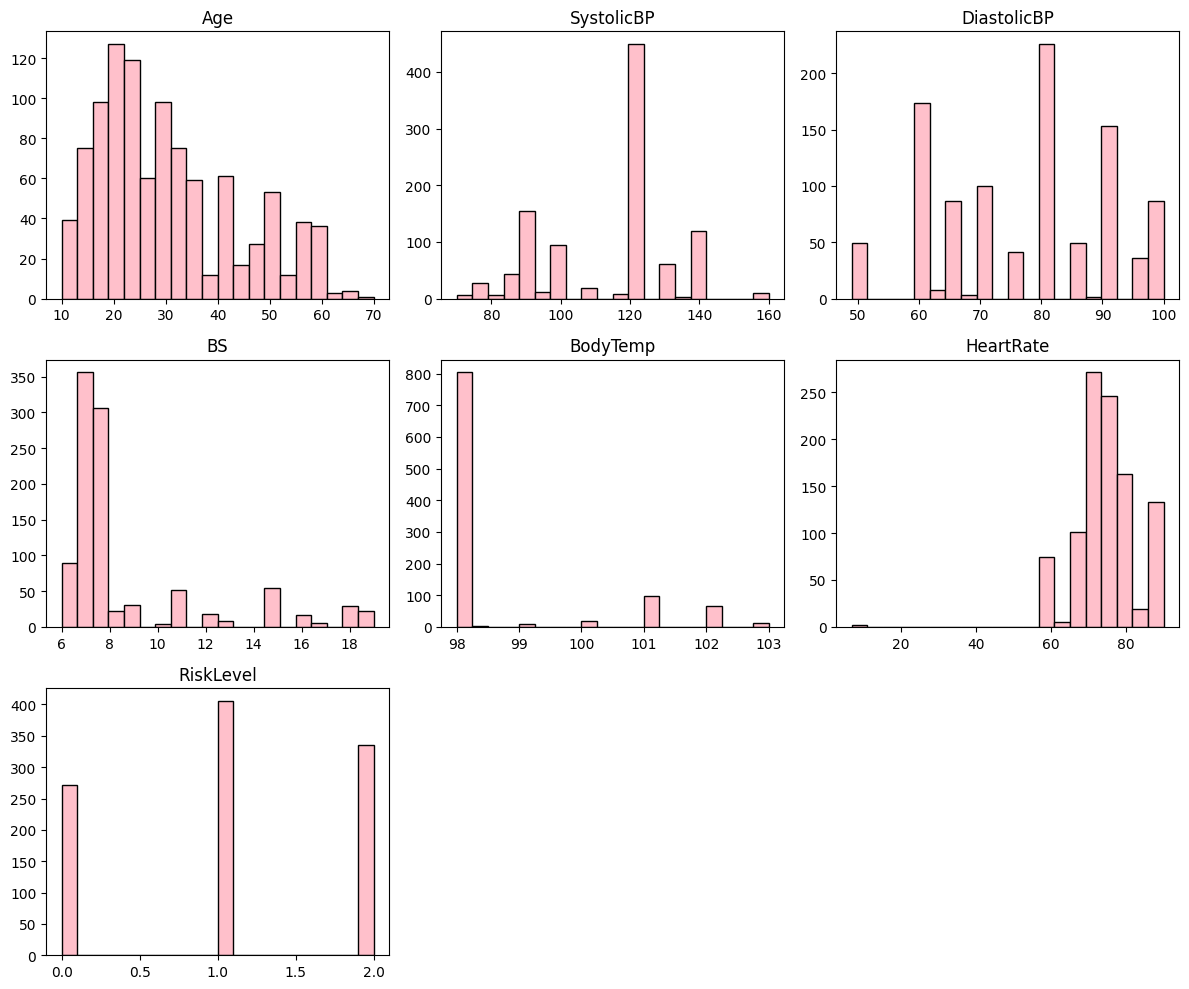

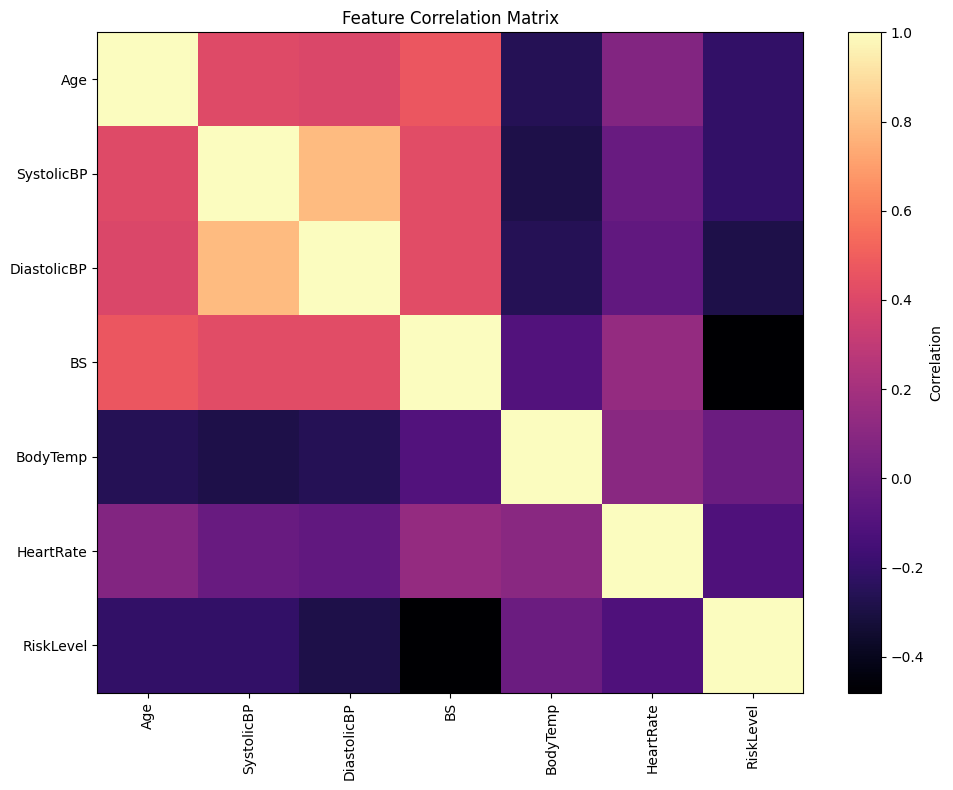

In [ ]:
# Histograms of numeric features
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i + 1)
    plt.hist(data[col], bins=20, color='pink', edgecolor='black')
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation matrix
corr = data.corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='magma', aspect='auto')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

Outlier Handling

/tmp/ipython-input-65-462567527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.where((data[col] < lower_bound) | (data[col] > upper_bound), median, data[col])
/tmp/ipython-input-65-462567527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.where((data[col] < lower_bound) | (data[col] > upper_bound), median, data[col])
/tmp/ipython-input-65-462567527.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

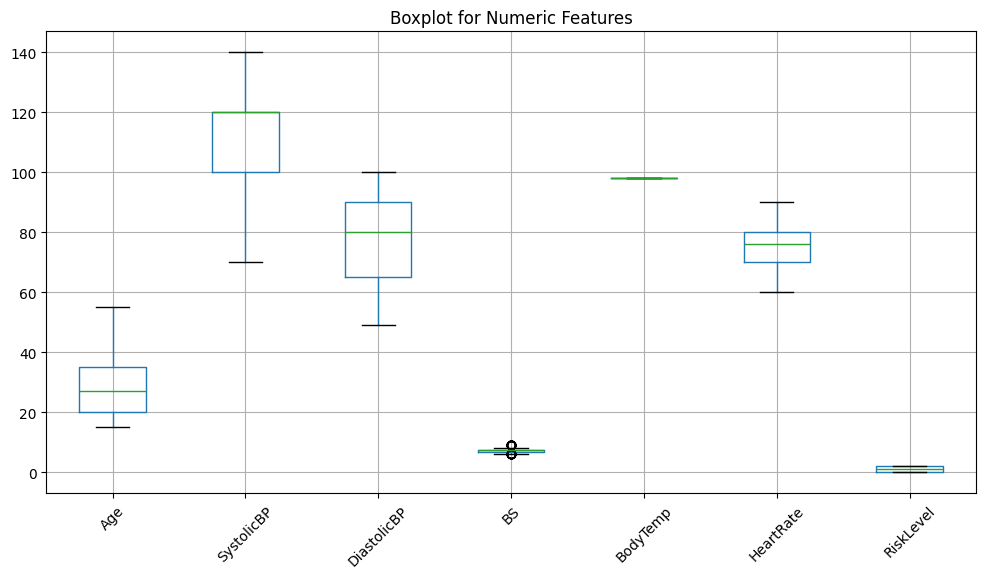

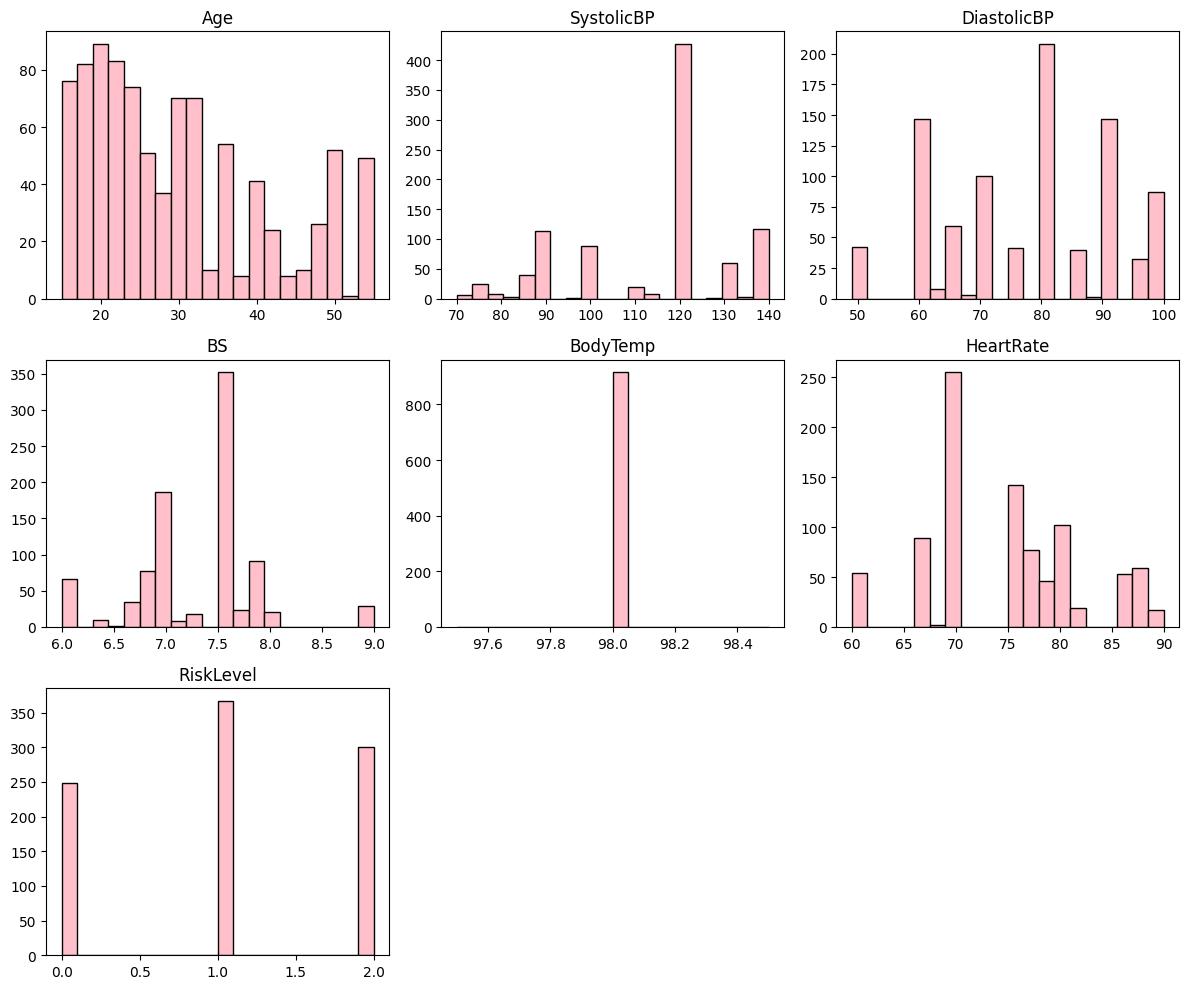

In [ ]:
# First filter Age range strictly
data = data[(data['Age'] >= 15) & (data['Age'] <= 55)]

outliers = {}

features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

for col in features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median = data[col].median()
    data[col] = np.where((data[col] < lower_bound) | (data[col] > upper_bound), median, data[col])

plt.figure(figsize=(12, 6))
data.boxplot(column=numeric_cols)
plt.title('Boxplot for Numeric Features')
plt.xticks(rotation=45)
plt.show()

# Histogram of cleaned data
plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i + 1)
    plt.hist(data[col], bins=20, color='pink', edgecolor='black')
    plt.title(col)
plt.tight_layout()
plt.show()

Feature Selection

In [ ]:
# Feature selection using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X, y)
scores = selector.scores_
feature_scores = pd.Series(scores, index=X.columns).sort_values(ascending=False)
print("\nFeature Scores (ANOVA F-test):")
display(feature_scores.to_frame(name='F-Score'))


Feature Scores (ANOVA F-test):


,F-Score
BS,331.158072
SystolicBP,95.902952
DiastolicBP,84.960133
Age,46.114005
HeartRate,20.452685
BodyTemp,16.445847


Scaling

In [ ]:
# StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Splitting Train and Test Data

In [ ]:
# Split the dataset
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

Model Training

In [ ]:
# Keep original unscaled version for LightGBM
X_train_raw, X_test_raw, _, _ = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define models
models = {
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMClassifier(num_leaves=15, min_data_in_leaf=5, learning_rate=0.1, n_estimators=100, random_state=42, verbose=-1)
}

# Train and evaluate
results = {}

for name, model in models.items():

    if name == 'LightGBM':
        model.fit(X_train_raw, y_train)
        y_pred = model.predict(X_test_raw)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

# Save directory
save_dir = "SavedModels"
os.makedirs(save_dir, exist_ok=True)

# Save models
joblib.dump(models['Random Forest'], os.path.join(save_dir, "random_forest_model.pkl"))
joblib.dump(models['SVM'], os.path.join(save_dir, "svm_model.pkl"))
joblib.dump(models['LightGBM'], os.path.join(save_dir, "lightgbm_model.pkl"))

# Save scaler and encoders
joblib.dump(scaler, os.path.join(save_dir, "scaler.pkl"))
joblib.dump(label_encoders, os.path.join(save_dir, "label_encoders.pkl"))

['SavedModels/label_encoders.pkl']

Model Evaluation

In [ ]:
for name, model in models.items():
    print(f"\n{name}")
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))



SVM
              precision    recall  f1-score   support

   High Risk       0.95      0.90      0.93        82
    Low Risk       0.87      0.84      0.85       122
    Mid Risk       0.78      0.83      0.80       101

    accuracy                           0.86       305
   macro avg       0.86      0.86      0.86       305
weighted avg       0.86      0.86      0.86       305


Random Forest
              precision    recall  f1-score   support

   High Risk       0.95      0.90      0.93        82
    Low Risk       0.87      0.84      0.85       122
    Mid Risk       0.78      0.83      0.80       101

    accuracy                           0.86       305
   macro avg       0.86      0.86      0.86       305
weighted avg       0.86      0.86      0.86       305


LightGBM
              precision    recall  f1-score   support

   High Risk       0.95      0.90      0.93        82
    Low Risk       0.87      0.84      0.85       122
    Mid Risk       0.78      0.83      0.80  

Confusion Matrix


SVM


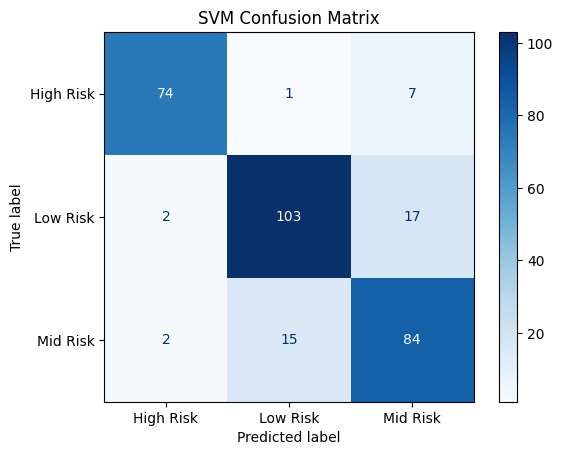


Random Forest


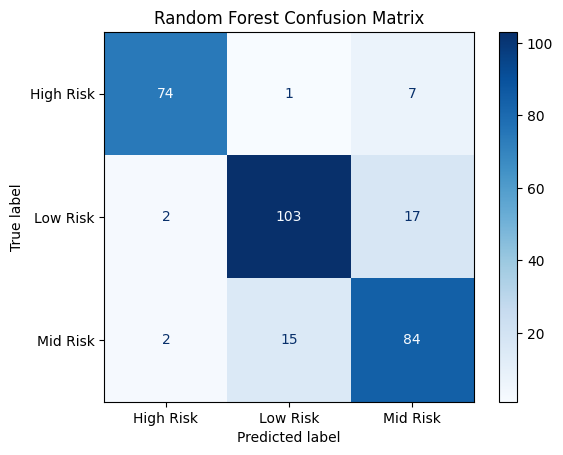


LightGBM


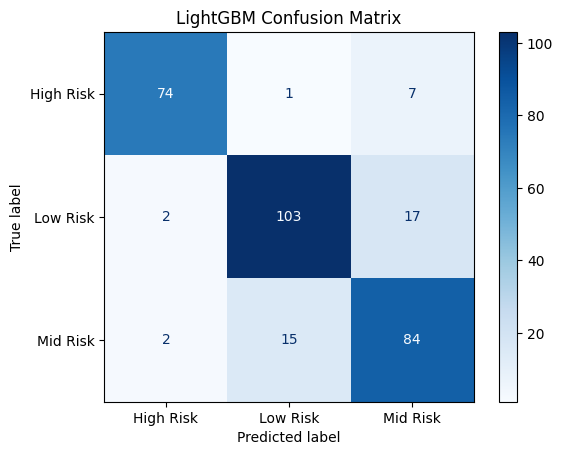

In [ ]:
for name, model in models.items():
    print(f"\n{name}")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


Accuracy Comparison Graph

SVM Accuracy: 0.6951
Random Forest Accuracy: 0.8525
LightGBM Accuracy: 0.8557


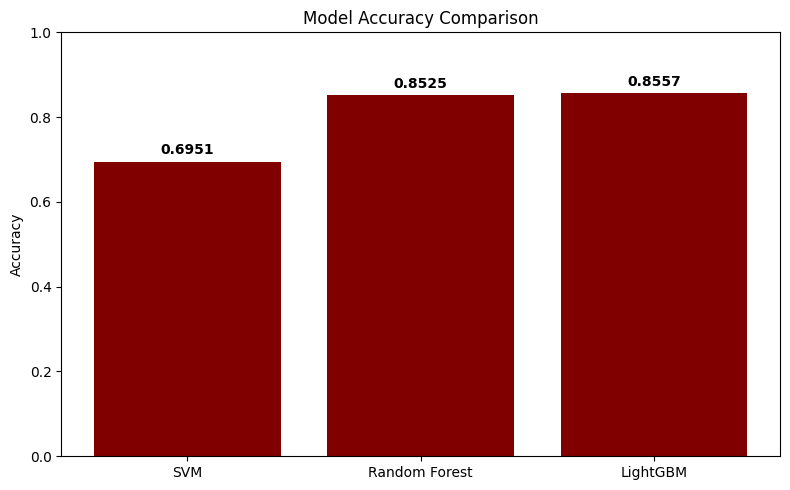

In [ ]:
# Dictionary to store accuracy scores
accuracy_scores = {}

for model_name, model in models.items():
    # Choose the right test set
    if model_name == 'LightGBM':
        X_input = X_test_raw          # for LightGBM (assuming it needs raw features)
    else:
        X_input = X_test_scaled       # for all the other models

    # Make predictions and compute accuracy
    y_pred = model.predict(X_input)
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores[model_name] = acc
    print(f"{model_name} Accuracy: {acc:.4f}")

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='maroon')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

for i, acc in enumerate(accuracy_scores.values()):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



SVM:
Train Accuracy: 0.7207,
Test Accuracy: 0.6951

Random Forest:
Train Accuracy: 0.9238,
Test Accuracy: 0.8525

LightGBM:
Train Accuracy: 0.9210,
Test Accuracy: 0.8557


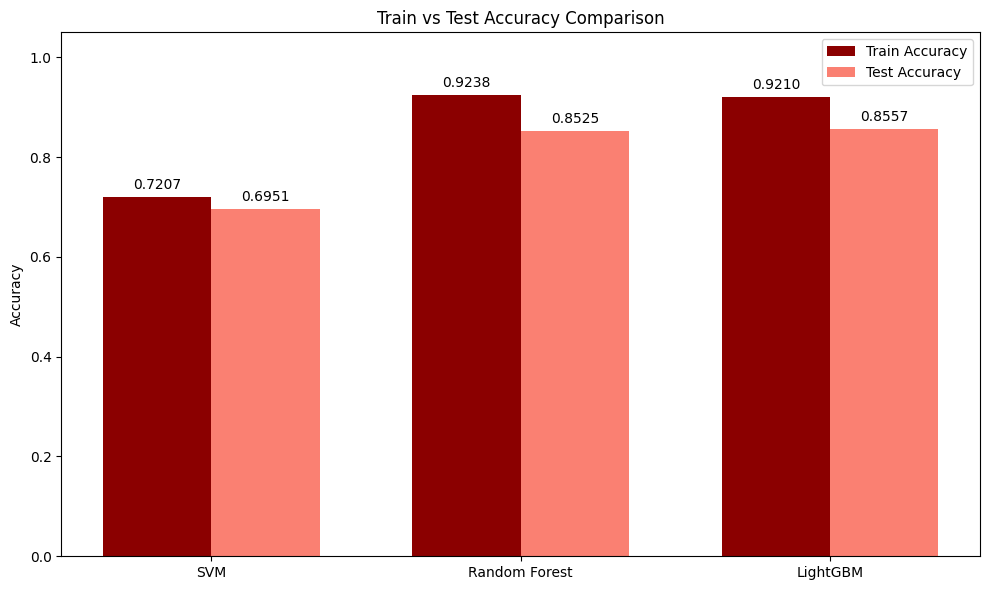

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Dictionaries to store accuracies
train_accuracies = {}
test_accuracies = {}

# Evaluate each model
for model_name, model in models.items():
    # Choose appropriate input (raw or scaled)
    if model_name == 'LightGBM':
        X_train_input = X_train_raw
        X_test_input = X_test_raw
    else:
        X_train_input = X_train_scaled
        X_test_input = X_test_scaled

    # Predictions
    y_train_pred = model.predict(X_train_input)
    y_test_pred = model.predict(X_test_input)

    # Accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Store results
    train_accuracies[model_name] = train_acc
    test_accuracies[model_name] = test_acc

    # Print values
    print(f"\n{model_name}:\nTrain Accuracy: {train_acc:.4f},\nTest Accuracy: {test_acc:.4f}")

    import numpy as np

# Bar plot for train and test accuracy
labels = list(train_accuracies.keys())
x = np.arange(len(labels))  # label locations
width = 0.35  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, train_accuracies.values(), width, label='Train Accuracy', color='darkred')
plt.bar(x + width/2, test_accuracies.values(), width, label='Test Accuracy', color='salmon')

# Annotate bars
for i in range(len(labels)):
    plt.text(x[i] - width/2, train_accuracies[labels[i]] + 0.01, f"{train_accuracies[labels[i]]:.4f}", ha='center', va='bottom')
    plt.text(x[i] + width/2, test_accuracies[labels[i]] + 0.01, f"{test_accuracies[labels[i]]:.4f}", ha='center', va='bottom')

plt.xticks(x, labels)
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy Comparison')
plt.legend()
plt.tight_layout()
plt.show()

Prediction from User Data

In [ ]:
def predict_risk_level(user_input_dict, model, label_encoders, scaler, feature_order):
    # Compute derived features
    user_input_dict["PulsePressure"] = user_input_dict["SystolicBP"] - user_input_dict["DiastolicBP"]
    user_input_dict["IsFever"] = 1 if user_input_dict["BodyTemp"] > 98.6 else 0

    # Create DataFrame
    user_df = pd.DataFrame([user_input_dict])

    # Ensure correct feature order
    user_df = user_df[feature_order]

    # Encode categorical features
    for col, le in label_encoders.items():
        if col in user_df.columns:
            user_df[col] = le.transform(user_df[col])

    # Scale features
    user_scaled = scaler.transform(user_df)

    # Predict
    pred_encoded = model.predict(user_scaled)[0]

    # Decode if needed
    if isinstance(pred_encoded, str):
        risk_level = pred_encoded
    else:
        risk_level = label_encoders['RiskLevel'].inverse_transform([pred_encoded])[0]

    return risk_level

# Change from set to list to maintain order
example_input = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

def get_user_input():
    user_data = {}
    for feature in example_input:
        val = input(f"Enter value for {feature}: ")
        try:
            if '.' in val:
                val = float(val)
            else:
                val = int(val)
        except ValueError:
            pass  # keep as string if conversion fails (likely categorical)
        user_data[feature] = val
    return user_data

# Use the actual feature order from your training data
feature_order = X.columns.tolist()

user_features = get_user_input()

if user_features:
    print("\nPredictions by Model:")
    for model_name, model in models.items():
        # Correct argument order: (user_input_dict, model, label_encoders, scaler, feature_order)
        predicted_risk = predict_risk_level(
            user_input_dict=user_features,
            model=model,
            label_encoders=label_encoders,
            scaler=scaler,
            feature_order=feature_order
        )
        print(f"{model_name}:\nPredicted Risk Level: {predicted_risk}")

Enter value for Age: 25
Enter value for SystolicBP: 120
Enter value for DiastolicBP: 80
Enter value for BS: 5.5
Enter value for BodyTemp: 98.6
Enter value for HeartRate: 72

Predictions by Model:
SVM:
Predicted Risk Level: Low Risk
Random Forest:
Predicted Risk Level: Low Risk
LightGBM:
Predicted Risk Level: Low Risk


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


# Model Summary (12 examples)

**SVM:**
Correctly Predicted: 6,
Incorrectly Predicted: 6,
Accuracy: 50%

**Random Forest:**
Correctly Predicted: 11,
Incorrectly Predicted:	1,
Accuracy: 92%

**LightGBM:**
Correctly Predicted: 4,
Incorrectly Predicted:	8,
Accuracy: 33%

Key Takeaways:
Random Forest is the **most clinically aligned** and reliable model (11/12 correct).

SVM is **too aggressive**, labeling many safe or mid-risk cases as **high risk**.

LightGBM is **underpredicting**, **missing serious risk indicators** like high BP, BS, and temperature.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Knowledge base
SYMPTOM_KB = {
    "dizzy": {
        "causes": "Low Blood pressure, Anemia, Dehydration",
        "tips": "Drink water, Eat small meals, Avoid standing too long. See a doctor if it persists."
    },
    "nausea": {
        "causes": "Common in the first trimester due to hormonal changes",
        "tips": "Eat ginger, Avoid greasy food, Try vitamin B6. Consult if it's severe."
    },
    "cramps": {
        "causes": "Uterus Expansion, Gas, or Implantation",
        "tips": "Mild is normal. Seek help if painful, constant, or with bleeding."
    },
    "swelling": {
        "causes": "fluid retention, preeclampsia (if sudden or severe)",
        "tips": "Elevate feet, Hydrate. Go to the doctor if you have vision changes or high BP."
    }
}

GREETING_KEYWORDS = ["hi", "hello", "hey"]
THANK_KEYWORDS = ["thanks", "thank you", "thankyou"]
EXIT_KEYWORDS = ["bye", "exit", "quit"]
OKAY_KEYWORDS = ["okay", "ok"]

def extract_intent_entities(text):
    doc = nlp(text.lower())
    tokens = [token.text for token in doc]
    entities = [ent.text for ent in doc.ents]
    return tokens, entities

def get_response(user_input):
    tokens, entities = extract_intent_entities(user_input)

    # Greetings
    if any(token in GREETING_KEYWORDS for token in tokens):
        return "Hello! I'm your maternal care assistant. How can I help?"

    # Exit
    if any(token in EXIT_KEYWORDS for token in tokens):
        return "Take care! Wishing you a healthy pregnancy."

    # Thanks
    if any(token in THANK_KEYWORDS for token in tokens):
        return "You're welcome! Let me know if you need anything else."

    # Thanks
    if any(token in OKAY_KEYWORDS for token in tokens):
        return "Let me know if you have any more questions."

    # Symptom detection
    for symptom in SYMPTOM_KB:
        if symptom in user_input.lower():
            data = SYMPTOM_KB[symptom]
            return (f"It sounds like you're experiencing {symptom}.\n"
                    f"Possible causes: {data['causes']}.\n"
                    f"Advice: {data['tips']}")

    # Risk / prediction related
    if "risk" in user_input or "prediction" in user_input:
        return ("To assess pregnancy risk, I need your age, blood pressure, sugar level, and temperature. "
                "Have you entered those in the system?")

    return "I'm still learning. Could you rephrase or describe your issue in more detail?"

# Main chat loop
print("🤖: Hello! Ask me anything about pregnancy health.")
while True:
    user_input = input("You: ")
    if user_input.lower() in EXIT_KEYWORDS:
        print("🤖:", get_response(user_input))
        break
    print("🤖:", get_response(user_input))


🤖: Hello! Ask me anything about pregnancy health.
You: I feel dizzy
🤖: It sounds like you're experiencing dizzy.
Possible causes: Low Blood pressure, Anemia, Dehydration.
Advice: Drink water, Eat small meals, Avoid standing too long. See a doctor if it persists.
You: Thankyou
🤖: You're welcome! Let me know if you need anything else.
You: Bye
🤖: Take care! Wishing you a healthy pregnancy.
